# Target Trial Emulation with Clustering

This Jupyter Notebook follows the instructions for Assignment 1 on Clustering. It implements Target Trial Emulation (TTE) by converting R code to Python and introduces clustering as an additional step.

In [1]:
import pandas as pd
import numpy as np
import os
from lifelines import CoxPHFitter
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from IPython.display import display

# Set environment variable to avoid Joblib warning
os.environ['LOKY_MAX_CPU_COUNT'] = '4'

## Step 1: Load the Dataset
The dummy dataset is extracted and stored as `data_censored.csv`.

In [2]:
# Generate dummy data similar to the R example
np.random.seed(123)
def generate_dummy_data(sample_size=1000):
    data = {
        'id': np.arange(1, sample_size + 1),
        'age': np.random.randint(30, 80, size=sample_size),
        'treatment': np.random.choice([0, 1], size=sample_size),
        'x1': np.random.choice([0, 1], size=sample_size),
        'x2': np.random.normal(0, 1, size=sample_size),
        'event_time': np.random.exponential(10, size=sample_size),
        'censoring': np.random.choice([0, 1], size=sample_size, p=[0.9, 0.1])
    }
    df = pd.DataFrame(data)
    df['censored'] = 1 - df['censoring']
    return df

# Save dataset
df = generate_dummy_data()
df.to_csv('data_censored.csv', index=False)
display(df.head())

,id,age,treatment,x1,x2,event_time,censoring,censored
0,1,75,1,0,-1.630621,1.558495,0,1
1,2,32,1,1,0.623903,1.113189,0,1
2,3,58,0,0,0.729245,2.657488,0,1
3,4,64,0,0,-0.848274,7.364607,0,1
4,5,68,1,0,-1.448712,10.396283,0,1


## Step 2: Handling Censoring with IPCW
Inverse Probability of Censoring Weights (IPCW) are computed using logistic regression.

In [3]:
censoring_model = LogisticRegression()
features = ['age', 'x1', 'x2']
X = df[features]
y = df['censoring']
censoring_model.fit(X, y)
df['censoring_prob'] = censoring_model.predict_proba(X)[:, 1]
df['ipcw'] = 1 / np.clip(df['censoring_prob'], 0.05, 5)

## Step 3: Clustering Patients (Added in TTE-v2)
K-Means clustering is applied to identify subgroups.

In [4]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[features])
kmeans = KMeans(n_clusters=3, random_state=42, n_init='auto')
df['cluster'] = kmeans.fit_predict(scaled_features)

## Step 4: Fitting a Cox Proportional Hazards Model
Survival analysis using CoxPHFitter.

In [5]:
cph = CoxPHFitter(penalizer=0.1)
cph.fit(df[['event_time', 'censored', 'treatment', 'ipcw', 'cluster']], 
        duration_col='event_time', event_col='censored', weights_col='ipcw', robust=True)
cph.print_summary()

model,lifelines.CoxPHFitter
duration col,'event_time'
event col,'censored'
weights col,'ipcw'
penalizer,0.1
l1 ratio,0.0
robust variance,True
baseline estimation,breslow
number of observations,9674.55
number of events observed,8674.03
partial log-likelihood,-70943.26


## Step 5: Survival Curves Visualization
Survival curves grouped by clusters.

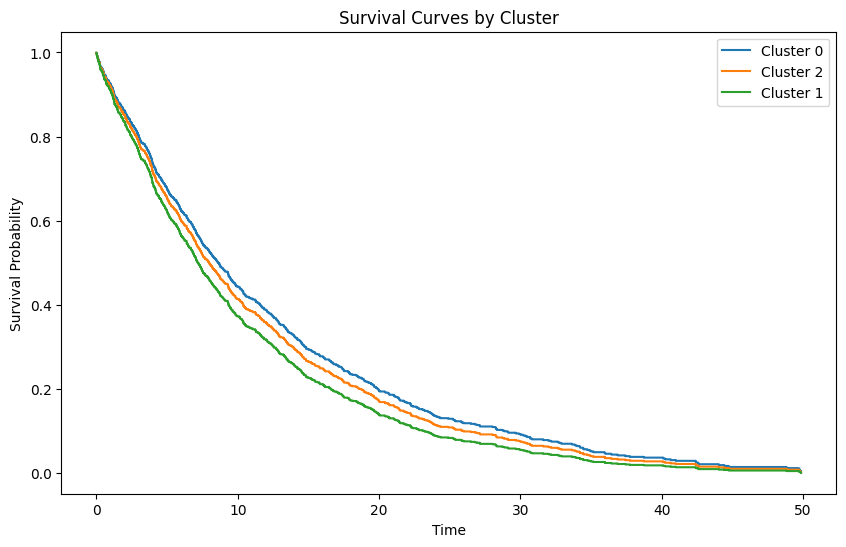

In [6]:
survival_function = cph.predict_survival_function(df)
plt.figure(figsize=(10, 6))
for cluster in df['cluster'].unique():
    plt.step(survival_function.index, survival_function.iloc[:, cluster], where='post', label=f'Cluster {cluster}')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.title('Survival Curves by Cluster')
plt.legend()
plt.show()

## Conclusion
This notebook follows the Target Trial Emulation methodology and integrates clustering to identify subgroups for improved analysis.